In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import tensorflow_text as text  # Registers the ops.
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [10]:
Train_Data = pd.read_csv('/kaggle/input/chota-final/final_data (1).csv')
Train_Data

,Unnamed: 0.1,Unnamed: 0,text,generated
0,0,0.0,Cars. Cars have been around since they became ...,0
1,1,1.0,Transportation is a large necessity in most co...,0
2,2,2.0,"""America's love affair with it's vehicles seem...",0
3,3,3.0,How often do you ride in a car? Do you drive a...,0
4,4,4.0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
415218,415218,NaN,"The real thing about him is he's a father, a p...",0
415219,415219,NaN,"Meanwhile at the time, it kept replaying in my...",0
415220,415220,NaN,so you have to get a lot of knowledge to achiv...,0
415221,415221,NaN,. That's why it is important for students t...,0


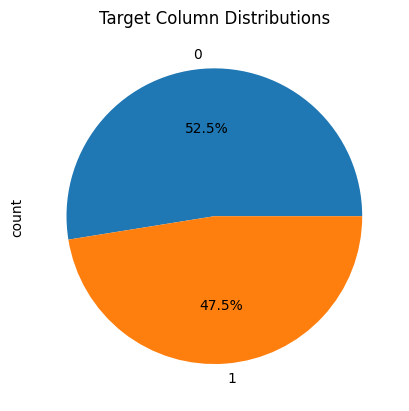

In [11]:
Train_Data.generated.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train,x_test,y_train,y_test=train_test_split(Train_Data.text,Train_Data.generated,test_size=0.006,shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(412731,)
(2492,)
(412731,)
(2492,)


In [14]:
x_train

50844     Car Free Cities\r\n\r\nMany people use cars fo...
399281    In conclusion,there is always a second chance ...
226923    Distance learning can provide a number of adva...
345243    Culture is what is going on around the person ...
369172    . so if u do these things it could change you ...
                                ...                        
349309    PROMPT\n\nPrompt is somthing that can we done ...
213577    Optimism and enthusiasm empower a person to ta...
410083    There is positive and negative things for bein...
364580    Furthermore, teenagers and kids would have a b...
169401    \n    \nAccording to the National Center for E...
Name: text, Length: 412731, dtype: object

In [15]:
path ="/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2"

## Create Model

## BERT Preprocess Data
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string , name='input')
bert_preprocess = hub.KerasLayer("/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3")
preprocessed_text = bert_preprocess(text_input)

## Use BERT Model
bert_encoder = hub.KerasLayer("/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2")
outputs = bert_encoder(preprocessed_text)
net = outputs['pooled_output']
sequence_output = outputs['sequence_output']

l = tf.keras.layers.Dropout(0.1 , name="dropout")(net)
d = tf.keras.layers.Dense(1 , activation='sigmoid' , name='output')(l)

model = tf.keras.Model(inputs=[text_input] , outputs=[d])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_type_ids': (None,    0         ['input[0][0]']               
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [14]:
import tensorflow as tf
import tensorflow_hub as hub

path = "/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2"

## Create Model
import tensorflow_text
## BERT Preprocess Data
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='input')
bert_preprocess = hub.KerasLayer("/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3")
preprocessed_text = bert_preprocess(text_input)

## Use BERT Model
bert_encoder = hub.KerasLayer("/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-768-a-12/2")
outputs = bert_encoder(preprocessed_text)
pooled_output = outputs['pooled_output']
sequence_output = outputs['sequence_output']

# LSTM layer
lstm_output, _, _, _, _ = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)
)(sequence_output)

# Global Max Pooling 
global_max_pooling = tf.reduce_max(sequence_output, axis=1)  # Use reduce_max instead

# Expand dimensions of global_max_pooling to match lstm_output
expanded_global_max_pooling = tf.expand_dims(global_max_pooling, axis=1)

# Tile the expanded global_max_pooling to match the sequence length of lstm_output
tiled_global_max_pooling = tf.tile(expanded_global_max_pooling, [1, tf.shape(lstm_output)[1], 1])

# Tile the pooled_output to match the sequence length of lstm_output
tiled_pooled_output = tf.tile(tf.expand_dims(pooled_output, axis=1), [1, tf.shape(lstm_output)[1], 1])

# Concatenate the tensors
concatenated_output = tf.concat([lstm_output, tiled_global_max_pooling, tiled_pooled_output], axis=-1)

# Dense layers
dense1 = tf.keras.layers.Dense(128, activation='relu')(concatenated_output)
dense2 = tf.keras.layers.Dense(64, activation='relu')(dense1)

# Final Dropout layer
final_dropout = tf.keras.layers.Dropout(0.3, name="final_dropout")(dense2)

# Output layer
dense_out = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(final_dropout)

# Create the model
model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 keras_layer_8 (KerasLayer)  {'input_word_ids': (None,    0         ['input[0][0]']               
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
history = model.fit(x_train, y_train , batch_size=128 , epochs=7 , validation_data=(x_test, y_test))

Epoch 1/7
3225/3225 [==============================] - 3636s 1s/step - loss: 0.1246 - accuracy: 0.9593 - val_loss: 0.0898 - val_accuracy: 0.9731
Epoch 2/7
3225/3225 [==============================] - 3608s 1s/step - loss: 0.0900 - accuracy: 0.9687 - val_loss: 0.0833 - val_accuracy: 0.9731
Epoch 3/7
3225/3225 [==============================] - 3604s 1s/step - loss: 0.0872 - accuracy: 0.9695 - val_loss: 0.0774 - val_accuracy: 0.9735
Epoch 4/7
3225/3225 [==============================] - 3602s 1s/step - loss: 0.0859 - accuracy: 0.9699 - val_loss: 0.0751 - val_accuracy: 0.9747
Epoch 5/7
3225/3225 [==============================] - 3605s 1s/step - loss: 0.0856 - accuracy: 0.9698 - val_loss: 0.0738 - val_accuracy: 0.9747
Epoch 6/7
3225/3225 [==============================] - 3604s 1s/step - loss: 0.0856 - accuracy: 0.9698 - val_loss: 0.0755 - val_accuracy: 0.9755
Epoch 7/7
3225/3225 [==============================] - 3601s 1s/step - loss: 0.0852 - accuracy: 0.9698 - val_loss: 0.0730 - val_ac

In [17]:
loss , acc = model.evaluate(x_train, y_train)
print("Accuracy on Train data:",acc)


12898/12898 [==============================] - 2726s 211ms/step - loss: 0.0686 - accuracy: 0.9764
Accuracy on Train data: 0.9764471054077148
78/78 [==============================] - 16s 210ms/step - loss: 0.0730 - accuracy: 0.9747
Accuracy on Test data: 0.9747191071510315


In [18]:
model.save("my_model")

In [ ]:
print('hi')

In [22]:
import pickle
pickle.dump(model,open("my_model.h5","wb"))

In [23]:
loss , acc = model.evaluate(x_test, y_test)
print("Accuracy on Test data:",acc)

78/78 [==============================] - 16s 211ms/step - loss: 0.0730 - accuracy: 0.9747
Accuracy on Test data: 0.9747191071510315


In [ ]:
test_essay

In [ ]:
loss , acc = model.evaluate(x_test, y_test)
print("Accuracy on Test data:",acc)

In [40]:
y_pred = model.predict(test_essay['text'])

1/1 [==============================] - 1s 838ms/step


In [41]:
y_pred

array([[0.1184279 ],
       [0.00977272],
       [0.0170719 ]], dtype=float32)

In [42]:
y_pred[:,0]

array([0.1184279 , 0.00977272, 0.0170719 ], dtype=float32)

In [43]:
# Assuming 'test_ids' are the IDs of test samples, and 'predictions' are the predicted values
submission = pd.DataFrame({'id': test_essay['id'] , 'generated': y_pred[:,0] })
submission.to_csv('submission.csv', index=False)  # Save the CSV file